<a href="https://colab.research.google.com/github/shahansh22/diabetes-prediction-cnn/blob/main/DenseNet121_diabetes_new_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
train_dir = '/content/drive/MyDrive/images/train_images'
train_csv = '/content/drive/MyDrive/images/train_images/train_labels.csv'
test_dir= '/content/drive/MyDrive/images/test_images'
test_csv= '/content/drive/MyDrive/images/test_images/test_labels.csv'

In [ ]:
# Define image dimensions
img_width, img_height = 244, 244 # Adjust based on your model's input size
# Read data from CSV
train= pd.read_csv(train_csv)
test=pd.read_csv(test_csv)
train_df=train.sample(frac=1).reset_index(drop=True)

<ipython-input-5-b40a295ad50b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="level", data=train, palette="GnBu_d")


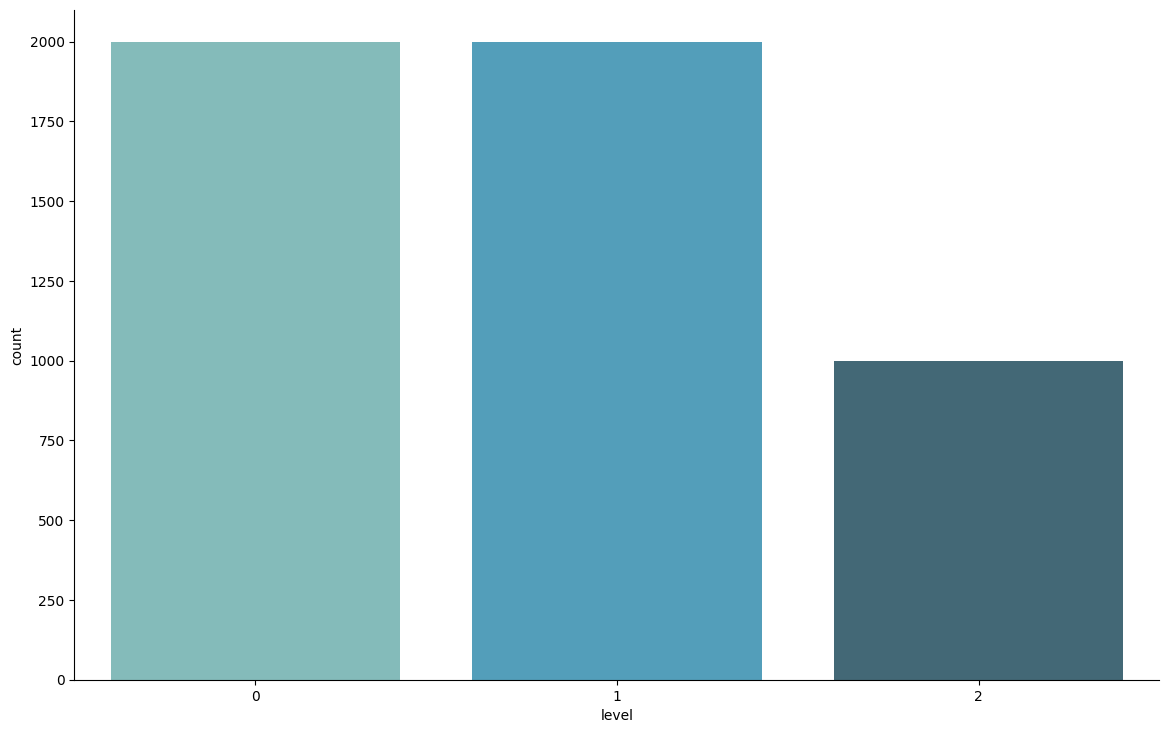

In [ ]:
# Label Class Distribution
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="level", data=train, palette="GnBu_d")
sns.despine()
plt.show()

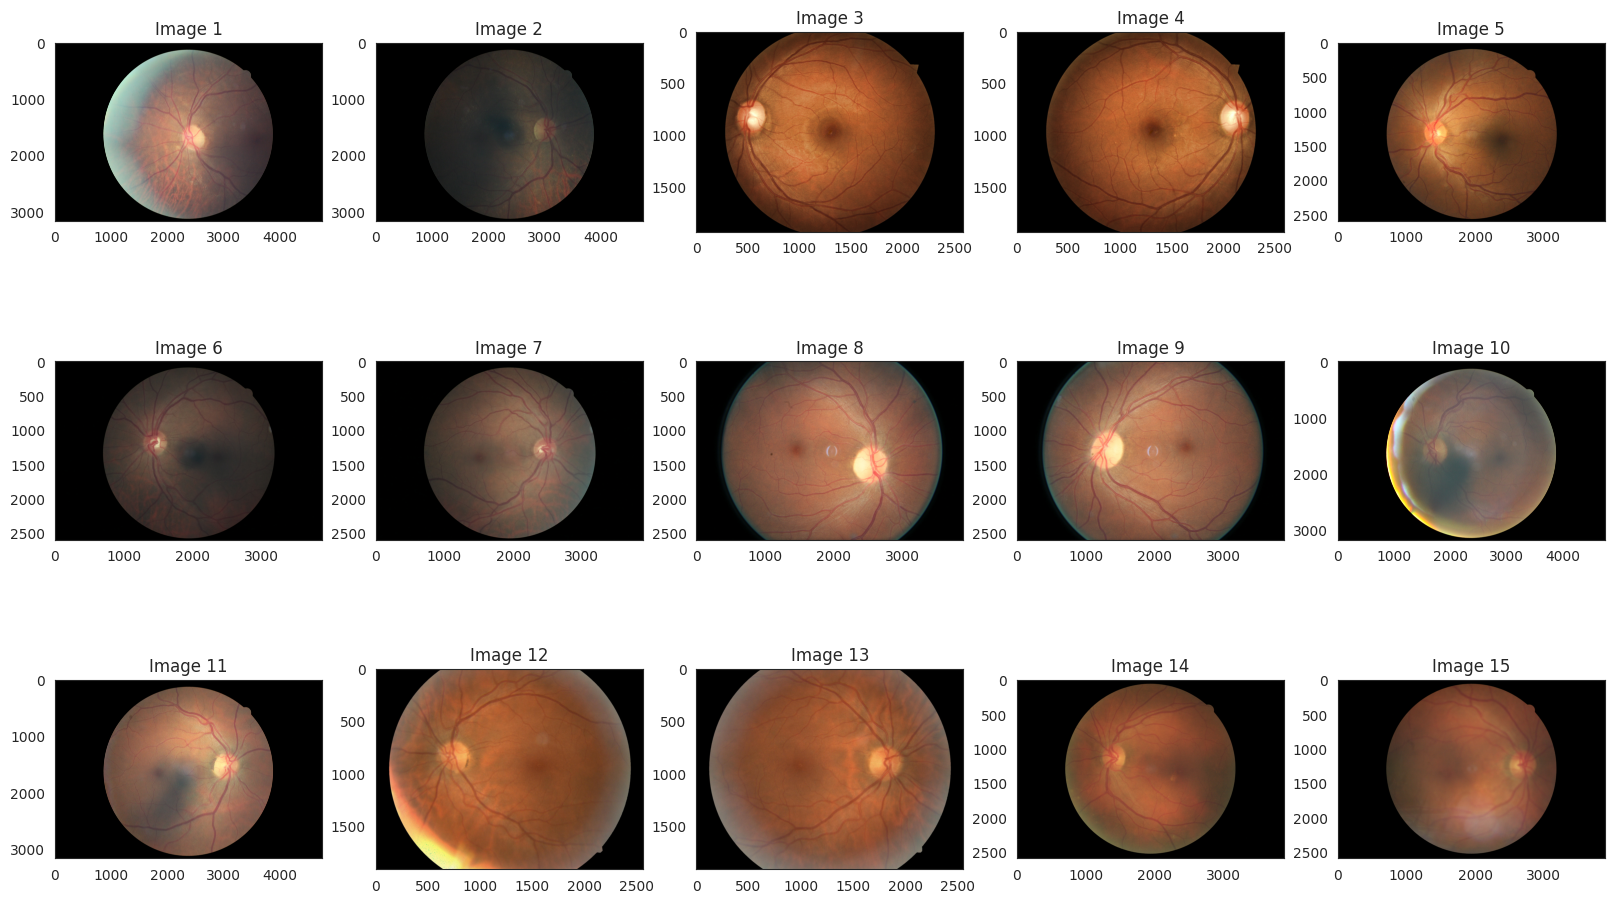

In [ ]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['image'][:15]:
    img = cv2.imread("/content/drive/MyDrive/images/train_images/%s.jpeg" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1

plt.show()

In [ ]:
train_df["image"] = train_df["image"]+".jpeg"
test["image"] = test["image"].apply(lambda x: x + ".jpeg")
train_df['level'] = train_df['level'].astype('str')
test['level'] = test['level'].astype('str')
train.tail()

,image,level
4995,28435_left,2
4996,28435_right,2
4997,28524_right,2
4998,28549_left,2
4999,28549_right,2


In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2,
                                 horizontal_flip=True
                                 )

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="image",
    y_col="level",
    batch_size=32,
    class_mode="categorical",
    target_size=(img_height,img_width ),
    shuffle=True,
    subset='training'
    )

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col="image",
    y_col="level",
    batch_size=32,
    class_mode="categorical",
    target_size=(img_height,img_width),
    shuffle=True,
    subset='validation'
    )

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = test_dir,
        x_col="image",
        target_size=(img_height, img_width),
        batch_size=1,
        shuffle=False,
        class_mode=None,
        )

Found 4000 validated image filenames belonging to 3 classes.
Found 1000 validated image filenames belonging to 3 classes.
Found 1581 validated image filenames.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Choose pre-trained model (InceptionV3)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Create a new model on top of the InceptionV3 base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3,activation='softmax')
])

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
batch_size=32
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras import optimizers
for layer in model.layers:
    layer.trainable = True

#es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-6, verbose=1)

callback_list = [rlrop]
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # You can adjust the number of epochs as needed
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
).history

Epoch 1/10
125/125 [==============================] - 2791s 22s/step - loss: 0.6045 - accuracy: 0.4942 - val_loss: 0.6832 - val_accuracy: 0.4466
Epoch 2/10
125/125 [==============================] - 317s 3s/step - loss: 0.5076 - accuracy: 0.5953 - val_loss: 0.5531 - val_accuracy: 0.5383
Epoch 3/10
125/125 [==============================] - 333s 3s/step - loss: 0.4497 - accuracy: 0.6597 - val_loss: 0.6511 - val_accuracy: 0.5000
Epoch 4/10
125/125 [==============================] - 325s 3s/step - loss: 0.4019 - accuracy: 0.7105 - val_loss: 0.5789 - val_accuracy: 0.5806
Epoch 5/10
125/125 [==============================] - 331s 3s/step - loss: 0.3551 - accuracy: 0.7520 - val_loss: 0.5092 - val_accuracy: 0.5958
Epoch 6/10
125/125 [==============================] - 337s 3s/step - loss: 0.2999 - accuracy: 0.8062 - val_loss: 0.6259 - val_accuracy: 0.5383
Epoch 7/10
125/125 [==============================] - 318s 3s/step - loss: 0.2271 - accuracy: 0.8650 - val_loss: 0.7306 - val_accuracy: 0.57

In [ ]:
model.save('/content/drive/MyDrive/images/DenseNet121.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


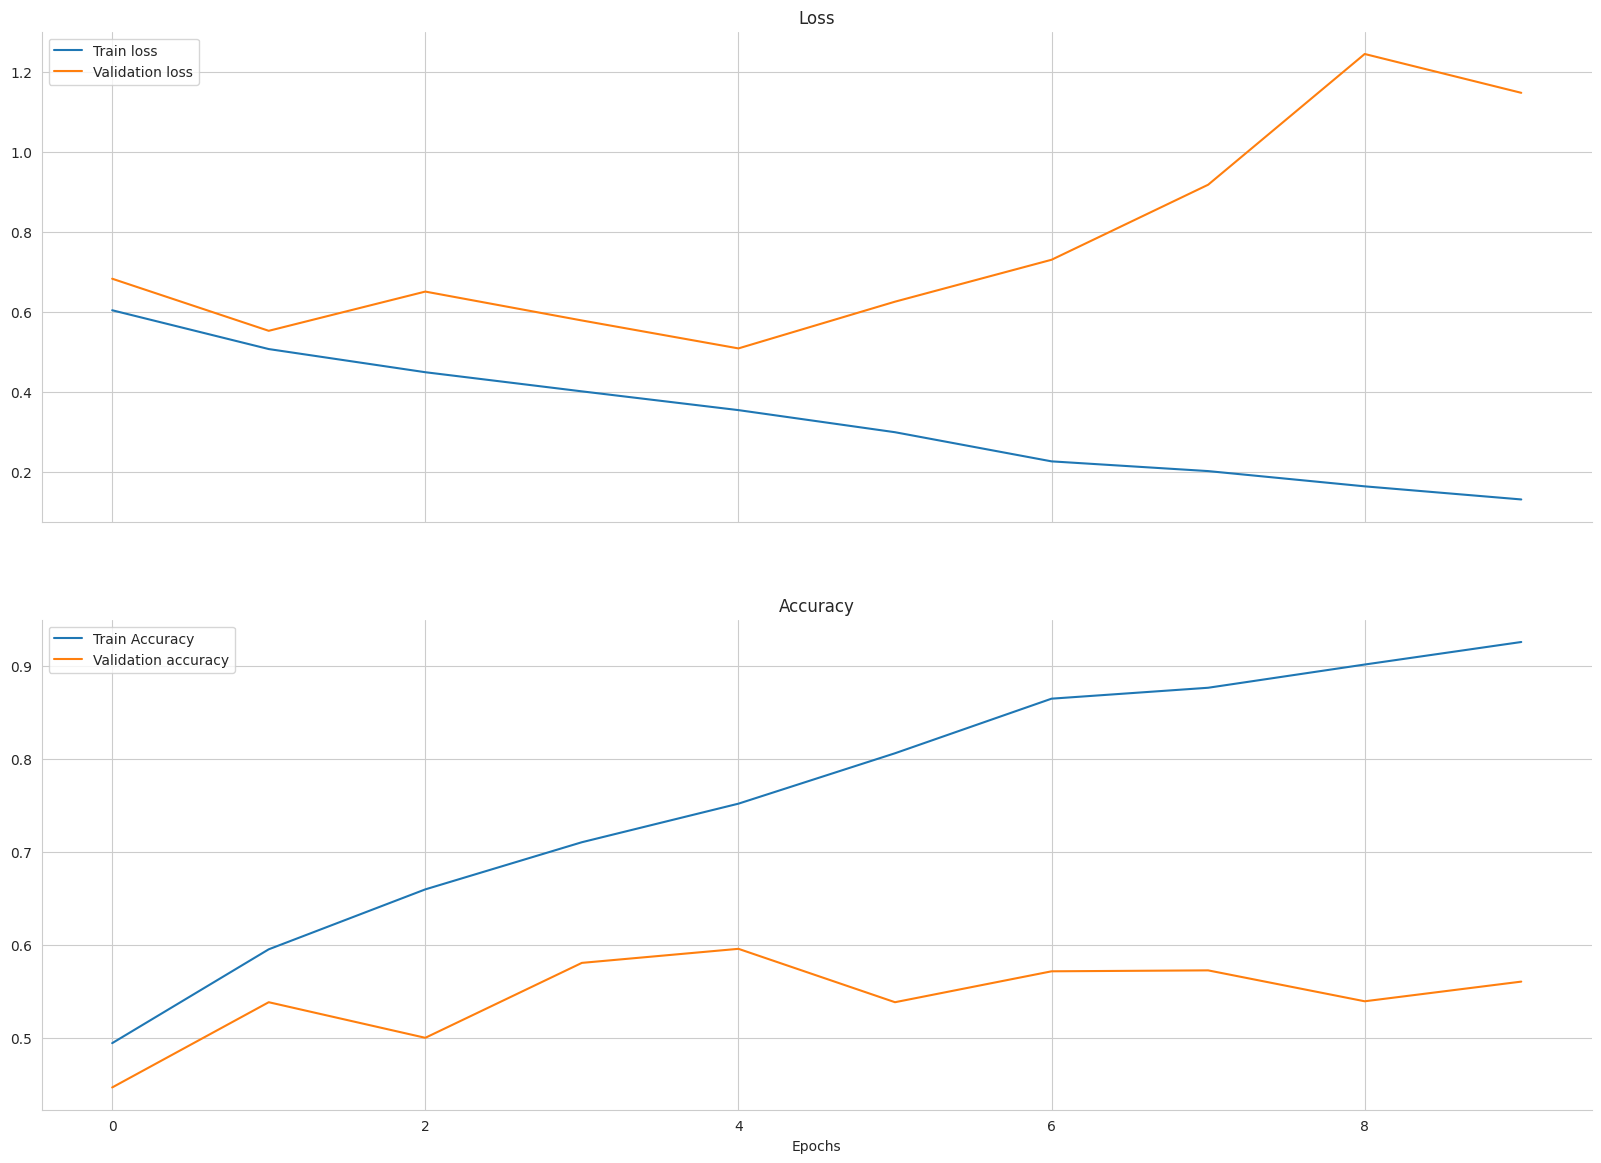

In [ ]:
# Model loss graph
history = {
    'loss': history['loss'],
    'val_loss': history['val_loss'],
    'accuracy': history['accuracy'],
    'val_accuracy': history['val_accuracy']
}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

1581/1581 [==============================] - 844s 532ms/step


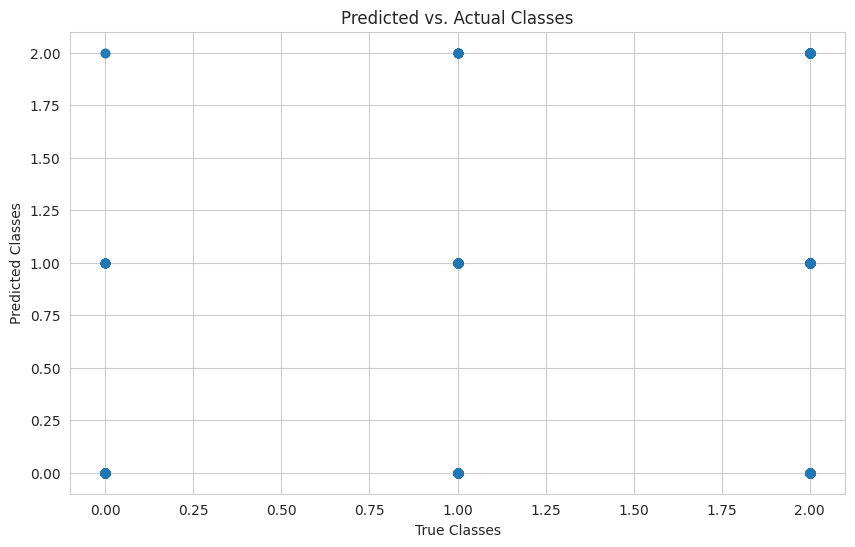

In [ ]:
import numpy as np
# Predict classes of test images
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

## Load the CSV file into a DataFrame
test_csv = pd.read_csv('/content/drive/MyDrive/images/test_images/test_labels.csv')

# Extract the true class labels
true_classes = test_csv['level'].values
# Plot predicted vs. actual classes
plt.figure(figsize=(10, 6))
plt.scatter(true_classes, predicted_classes, alpha=0.5)
plt.xlabel('True Classes')
plt.ylabel('Predicted Classes')
plt.title('Predicted vs. Actual Classes')
plt.grid(True)
plt.show()

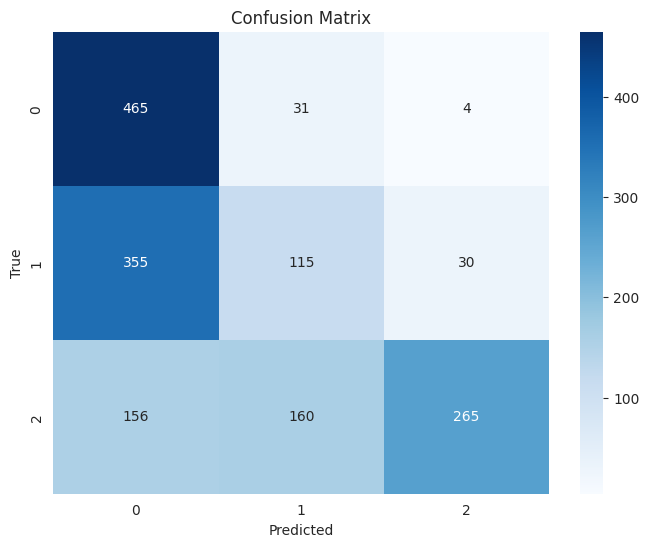

In [ ]:
import seaborn as sns
# Plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Print classification report
print("Classification Report:\n", classification_report(true_classes,predicted_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.93      0.63       500
           1       0.38      0.23      0.29       500
           2       0.89      0.46      0.60       581

    accuracy                           0.53      1581
   macro avg       0.58      0.54      0.51      1581
weighted avg       0.60      0.53      0.51      1581

